## install libraries

In [1]:
!pip install -U unsloth


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.7/311.7 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.9/511.9 kB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.8/184.8 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.2/129.2 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.6/213.6 kB 12.7 MB/s eta 0:00:00
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0


## Imports

In [2]:
from unsloth import FastLanguageModel
from transformers import Trainer, TrainingArguments
from datasets import load_dataset
import torch, random, os
from typing import Dict, List, Any
from transformers.data.data_collator import DefaultDataCollator
SEED = 42


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


## Load model and Tokenizer

In [3]:
model, tokenizer = FastLanguageModel.from_pretrained(
    "Qwen/Qwen3-4B-Instruct-2507",
    max_seq_length = 4096,
    dtype = torch.float16,
    load_in_4bit = True,
)

FastLanguageModel.for_training(model)
model = FastLanguageModel.get_peft_model(
    model,
    r=32,
    target_modules=["q_proj","k_proj","v_proj","o_proj","gate_proj","up_proj","down_proj"],
    lora_alpha=32,
    lora_dropout=0.0,
    use_rslora=True,
)


==((====))==  Unsloth 2025.8.9: Fast Qwen3 patching. Transformers: 4.55.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/3.55G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/237 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

Unsloth 2025.8.9 patched 36 layers with 36 QKV layers, 36 O layers and 36 MLP layers.


In [4]:

RESPONSE_TAG = "<|response|>"
tokenizer.add_special_tokens({"additional_special_tokens": [RESPONSE_TAG]})
model.resize_token_embeddings(len(tokenizer))
response_token_id = tokenizer.convert_tokens_to_ids(RESPONSE_TAG)

## Format function

In [5]:
SPECIAL_TOKENS = ["<|response|>", "<|analysis|>", "<|forecast|>"]
num_added = tokenizer.add_special_tokens({"additional_special_tokens": SPECIAL_TOKENS})
if num_added > 0:
    model.resize_token_embeddings(len(tokenizer))

RESPONSE_TAG = "<|response|>"
ANALYSIS_TAG = "<|analysis|>"
FORECAST_TAG = "<|forecast|>"

response_token_id = tokenizer.convert_tokens_to_ids(RESPONSE_TAG)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.truncation_side = "left"
tokenizer.padding_side     = "right"


The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


In [6]:
import json


def normalize_output_to_commas(output: str) -> str:
    txt = str(output).strip()
    if txt.startswith("[") and txt.endswith("]"):
        try:
            arr = json.loads(txt)
            return ",".join(str(x).strip() for x in arr)
        except Exception:
            pass
    return ",".join([t.strip() for t in txt.split(",")])

def make_brief_analysis(thinking: str, limit_chars: int = 200) -> str:
    t = (thinking or "").strip()
    if not t:
        return "brief outlook based on the provided data"
    return t[:limit_chars].replace("\n", " ")

def format_chat(ex):
    instruction = ex.get("__index_level_0__", "") or ""
    user_input  = ex.get("__index_level_1__", "") or ""
    thinking    = ex.get("custom_bitcoin_dataset", "") or ""
    output      = ex.get("__index_level_2__", "") or ""

    post_input_directive = (
        "Please analyze it first and then give me 10 next day prices separated by comma."
    )
    user_block = f"{user_input}\n\n{post_input_directive}"

    brief_note = make_brief_analysis(thinking, limit_chars=200)
    normalized_output = normalize_output_to_commas(output)

    assistant_payload = (
        f"{RESPONSE_TAG}\n"
        f"{ANALYSIS_TAG} Analysis: {brief_note}\n\n"
        f"{FORECAST_TAG}\n{normalized_output}"
    )

    messages = [
        {"role": "system", "content": instruction},
        {"role": "user", "content": user_block},
        {"role": "assistant", "content": assistant_payload},
    ]
    return {"text": tokenizer.apply_chat_template(messages, tokenize=False)}

raw = load_dataset("tahamajs/not_clearned_bitcoin_dataset")
train_data = raw["train"].map(format_chat, remove_columns=raw["train"].column_names)

def tokenize_fn(ex):
    return tokenizer(ex["text"], truncation=True, max_length=4096, padding=False)

train_tok = train_data.map(tokenize_fn, batched=True, remove_columns=["text"])
train_tok = train_tok.shuffle(seed=SEED)



README.md:   0%|          | 0.00/479 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/43.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1843 [00:00<?, ? examples/s]

Map:   0%|          | 0/1843 [00:00<?, ? examples/s]

Map:   0%|          | 0/1843 [00:00<?, ? examples/s]

## Data callector

In [7]:
from transformers.tokenization_utils_base import PreTrainedTokenizerBase
from torch.nn.utils.rnn import pad_sequence
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

tokenizer.truncation_side = "left"
tokenizer.padding_side     = "right"

from transformers.tokenization_utils_base import PreTrainedTokenizerBase
from torch.nn.utils.rnn import pad_sequence
import torch
from typing import Dict, List, Any

def _find_subsequence(haystack: torch.Tensor, needle: torch.Tensor) -> int:
    if needle.numel() == 0 or haystack.numel() < needle.numel():
        return -1
    for i in range(haystack.numel() - needle.numel() + 1):
        if torch.equal(haystack[i:i+needle.numel()], needle):
            return i
    return -1

class DataCollatorMaskResponse:
    def __init__(self, tokenizer: PreTrainedTokenizerBase, response_token_id: int):
        self.tokenizer = tokenizer
        self.response_token_id = response_token_id

        assistant_start_str = tokenizer.apply_chat_template(
            [{"role":"assistant","content":""}],
            tokenize=False, add_generation_prompt=True
        )

        self.assistant_start_ids = torch.tensor(
            tokenizer(assistant_start_str, add_special_tokens=False)["input_ids"],
            dtype=torch.long
        )

    def __call__(self, features: List[Dict[str, Any]]) -> Dict[str, torch.Tensor]:
        input_ids_list      = [torch.tensor(f["input_ids"], dtype=torch.long) for f in features]
        attention_mask_list = [torch.tensor(f["attention_mask"], dtype=torch.long) for f in features]

        input_ids = pad_sequence(input_ids_list, batch_first=True,
                                 padding_value=self.tokenizer.pad_token_id)
        attention_mask = pad_sequence(attention_mask_list, batch_first=True, padding_value=0)

        labels = input_ids.clone()

        for i in range(labels.size(0)):
            row = input_ids[i]

            pos = (row == self.response_token_id).nonzero(as_tuple=True)
            start_idx = -1
            if len(pos[0]) > 0:
                start_idx = int(pos[0][0].item())

            if start_idx < 0 and self.assistant_start_ids.numel() > 0:
                j = _find_subsequence(row, self.assistant_start_ids)
                if j >= 0:
                    start_idx = j + self.assistant_start_ids.numel() - 1

            if start_idx >= 0 and start_idx + 1 < row.numel():
                labels[i, : start_idx + 1] = -100
            else:
                keep = min(64, row.numel())
                labels[i, : row.numel() - keep] = -100

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels,
        }
collator = DataCollatorMaskResponse(tokenizer, response_token_id)



## Training Argumenst

In [8]:
args = TrainingArguments(
    output_dir="qwen_bitcoin_chat_fast",
    num_train_epochs=4,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=1,
    learning_rate=2e-3,
    max_steps=600,
    logging_steps=2,
    save_steps=200,
    bf16=False,
    fp16=True,
    optim="adamw_torch",
    lr_scheduler_type="cosine",
    warmup_ratio=0.05,
    gradient_checkpointing=True,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_tok,
    tokenizer=tokenizer,
    data_collator=collator,
)

/tmp/ipython-input-2666261809.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [9]:
trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,843 | Num Epochs = 2 | Total steps = 600
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 1 x 1) = 4
 "-____-"     Trainable parameters = 66,060,288 of 4,087,852,544 (1.62% trained)


Step,Training Loss
2,3.247400
4,2.917100
6,8.547500
8,2.203900
10,2.249000
12,2.382500
14,2.222300
16,2.250600
18,7.874600
20,6.449300


Unsloth: Will smartly offload gradients to save VRAM!


/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:300: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:300: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
print("=== Sample formatted texts ===")
for i in range(2):
    print(train_data[i]["text"])
    print("="*80)

sample_batch = [train_to2k[i] for i in range(2)]
batch = collator(sample_batch)

print("\n=== Tokenized input_ids ===")
print(batch["input_ids"][0][:4000])
print("\nDecoded back:\n", tokenizer.decode(batch["input_ids"][0][:80]))

print("\n=== Labels ===")
print(batch["labels"][0][:4000])

masked_decoded = [
    tok if lab != -100 else "[MASK]"
    for tok, lab in zip(batch["input_ids"][0][:4000].tolist(), batch["labels"][0][:4000].tolist())
]
print("\nMasked Decoded (first 80 tokens):")
print(masked_decoded)


## Save model

In [10]:
trainer.model.save_pretrained("qwen_bitcoin_chat_fast/lora_adapter")
tokenizer.save_pretrained("qwen_bitcoin_chat_fast")


/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:300: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


('qwen_bitcoin_chat_fast/tokenizer_config.json',
 'qwen_bitcoin_chat_fast/special_tokens_map.json',
 'qwen_bitcoin_chat_fast/chat_template.jinja',
 'qwen_bitcoin_chat_fast/vocab.json',
 'qwen_bitcoin_chat_fast/merges.txt',
 'qwen_bitcoin_chat_fast/added_tokens.json',
 'qwen_bitcoin_chat_fast/tokenizer.json')

In [11]:
from huggingface_hub import notebook_login

notebook_login()

In [15]:
from huggingface_hub import HfApi, HfFolder

# Initialize the API client
api = HfApi()

# Your Hugging Face username and the desired repo name
hf_username = "tahamajs"  # <-- IMPORTANT: REPLACE WITH YOUR USERNAME
# repo_name = "qwen-bitcoin-chat-explicit"
local_folder_name = "qwen_bitcoin_chat_fast/lora_adapter"
repo_name = "qwen-bitcoin-chat-manual-Qwen3-4B-Instruct-2507" # This will be the name on the Hub

# --- Option A: Create a PUBLIC repository ---
api.create_repo(
    repo_id=f"{hf_username}/{repo_name}",
    repo_type="model",
    exist_ok=True,  # This prevents an error if the repo already exists
)
print(f"Public repo created: https://huggingface.co/{hf_username}/{repo_name}")
# Now, upload the contents to the repo you just created
api.upload_folder(
    folder_path=local_folder_name,
    repo_id=f"{hf_username}/{repo_name}",
    repo_type="model",
)


print(f"Private repo created: https://huggingface.co/{hf_username}/{repo_name}-private")

Public repo created: https://huggingface.co/tahamajs/qwen-bitcoin-chat-manual-Qwen3-4B-Instruct-2507


Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...a_adapter/adapter_model.safetensors:   2%|1         | 33.5MB / 1.82GB            

Private repo created: https://huggingface.co/tahamajs/qwen-bitcoin-chat-manual-Qwen3-4B-Instruct-2507-private


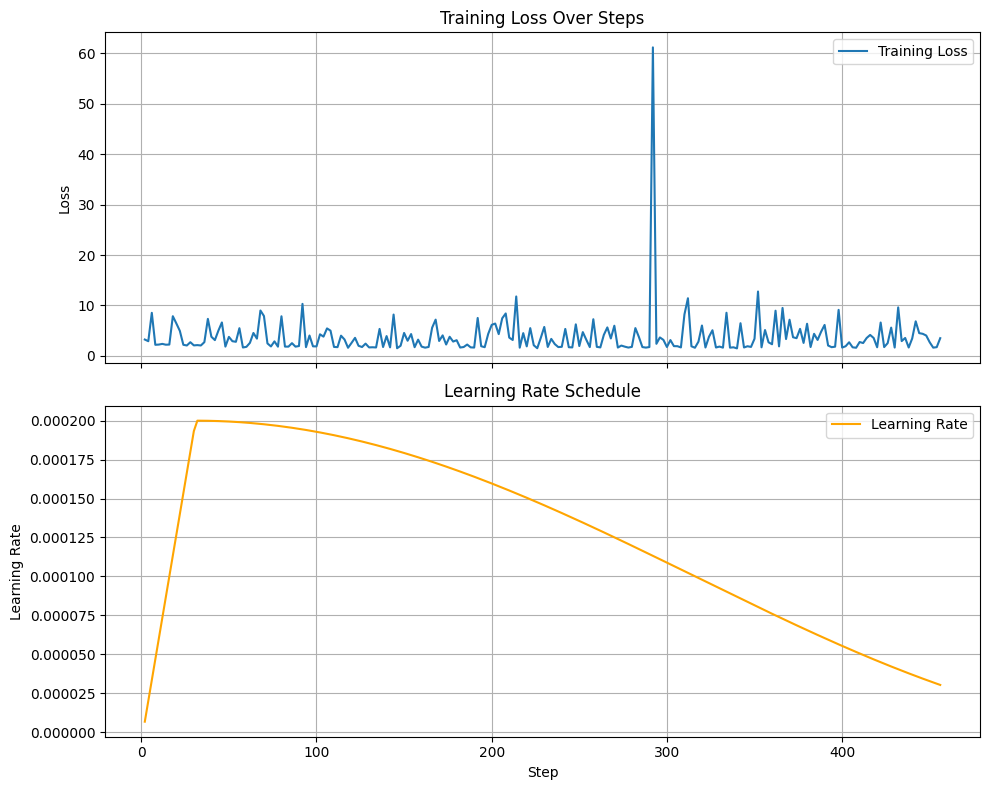

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# The log history is a list of dictionaries
log_history = trainer.state.log_history

# It's best to filter out the evaluation logs if you have any,
# here we focus on training logs which have a 'loss' key.
training_logs = [log for log in log_history if 'loss' in log]

# Convert the list of dictionaries to a pandas DataFrame
df = pd.DataFrame(training_logs)

# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot Training Loss on the first subplot
ax1.plot(df['step'], df['loss'], label='Training Loss')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss Over Steps')
ax1.legend()
ax1.grid(True)

# Plot Learning Rate on the second subplot
ax2.plot(df['step'], df['learning_rate'], label='Learning Rate', color='orange')
ax2.set_xlabel('Step')
ax2.set_ylabel('Learning Rate')
ax2.set_title('Learning Rate Schedule')
ax2.legend()
ax2.grid(True)

# Display the plots
plt.tight_layout()
plt.show()